In [2]:
# import sys
# sys.path.append(r'D:\GitProjects\pytorch-GNN\pytorch-GNN-2nd')


In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sat Apr 11 08:03:20 2020
@author: 代码医生工作室
@公众号：xiangyuejiqiren   （内有更多优秀文章及学习资料）
@来源: <PyTorch深度学习和图神经网络(卷2）——开发应用>配套代码
@配套代码技术支持：bbs.aianaconda.com
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import dgl
from dgl.nn.pytorch.conv import RelGraphConv

import re
import numpy as np
import pandas as pd

# 如何优雅import
from code_15_BERT_PROPN import (device, df_test, df_train_val, getmodel)

import spacy
import pickle
import collections

from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
from operator import itemgetter
from sklearn import metrics

cpu


In [4]:
base_dir = 'output/'

'''加载预处理文件'''

# 其他词 NoPUNC：no punctuation mark，即去掉标点符号
# 在训练数据集中，目标代词、名称A、名称B的偏移位置？
offsets_NoPUNC = pickle.load(open(base_dir + 'offsets_NoPUNC.pkl', "rb"))
# 在训练数据集中，文本的子词向量序列
tokens_NoPUNC = pickle.load(open(base_dir + 'tokens_NoPUNC_padding.pkl', "rb"))  # tokens of every sentence without padding
# # 在训练数据集中，BERT模型的输出结果
bert_forNoPUNC = pickle.load(open(base_dir + 'bert_outputs_forNoPUNC.pkl', "rb"))  # list of outputs of bert for every sentence
# 在训练数据集中，BERT last_hidden_state 中对应目标代词、名称A、名称B的那3个向量
PROPN_bert = pickle.load(open(base_dir + 'bert_outputs_forPROPN.pkl', "rb"))

# offsets_NoPUNC    2454,3
# tokens_NoPUNC     2454,266
# bert_forNoPUNC    2454,1,266,768
# PROPN_bert        2454,1,3,768

In [7]:
tokenizer, _ = getmodel()  # 加载BERT分词工具
# parser = spacy.load('en')  # 加载SpaCy模型  'en_core_web_sm')#en_core_web_lg
parser = spacy.load("en_core_web_sm")

['[THISISA]', '[THISISB]', '[THISISP]'] [30522, 30523, 30524]


Some weights of the model checkpoint at huggingface/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
# (70, 72, 75)
print(offsets_NoPUNC[0])
# [101, ..., 102, 0 * m]
print(tokens_NoPUNC[0])
print(offsets_NoPUNC[0][0])
print(tokens_NoPUNC[0][70])
# A: bob, B: de, P: his.
for i in range(3):
    for j in range(3):
        print(tokenizer.convert_ids_to_tokens(tokens_NoPUNC[i][offsets_NoPUNC[i][j]]), end=' ')
    print()

# print(bert_forNoPUNC[0])
# print(PROPN_bert[0])

(70, 72, 75)
[101, 2588, 2037, 9920, 2046, 1996, 12849, 26730, 15758, 3873, 2223, 2139, 2187, 6435, 2000, 3696, 1037, 3206, 1999, 2762, 2007, 15501, 2278, 1049, 13316, 10222, 1997, 1996, 3972, 2006, 2238, 2044, 11847, 1996, 2446, 2528, 2007, 1996, 1049, 13316, 10222, 2136, 1999, 2002, 2187, 1996, 2252, 1998, 2001, 3856, 2039, 2011, 3507, 3972, 2217, 15501, 2278, 4702, 9695, 1999, 2251, 2280, 7097, 2121, 5639, 10514, 3334, 1998, 4386, 12968, 3960, 2024, 2139, 1055, 27328, 2010, 5542, 2003, 5135, 3748, 1055, 6585, 2952, 4575, 10514, 3334, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [84]:
import inspect

def print_variable_name(variable):
    # 获取当前作用域的局部变量和全局变量
    frame = inspect.currentframe().f_back
    local_vars = frame.f_locals
    global_vars = frame.f_globals

    # 搜索变量并打印名称
    for name, value in local_vars.items():
        if value is variable:
            print(f"Variable Name (Local): {name}")
            return

    for name, value in global_vars.items():
        if value is variable:
            print(f"Variable Name (Global): {name}")
            return

    print("Variable Name: Not found")

# 示例变量
x = 42
y = [1, 2, 3]
z = "Hello"

# 查看变量名称
print_variable_name(x)
print_variable_name(y)
print_variable_name(z)
print_variable_name(offsets_NoPUNC)

Variable Name (Local): x
Variable Name (Local): y
Variable Name (Local): z
Variable Name (Local): offsets_NoPUNC


In [73]:
def print_variable_structure(variable, indent=""):
    print(f"{}\n")
    print(f"{indent}Type: {type(variable)}")
    if isinstance(variable, dict):
        print(f"{indent}Keys: {list(variable.keys())}")
        for key, value in variable.items():
            print(f"{indent}Key: {key}")
            print_variable_structure(value, indent + "  ")
            break
    elif isinstance(variable, (list, tuple, np.ndarray, torch.Tensor)):
        if isinstance(variable, (list, tuple)):
            print(f"{indent}Shape: {len(variable)}")
            if len(variable) == 0:
                return
        if isinstance(variable, (np.ndarray, torch.Tensor)):
            print(f"{indent}Shape: {variable.shape}")
            print(f"{indent}Data Type: {variable.dtype}")
            if isinstance(variable, (torch.Tensor)) and variable.dim() == 0 or \
                isinstance(variable, (np.ndarray)) and variable.ndim == 0 :
                return
        for index, value in enumerate(variable):
            print(f"{indent}Index: {index}")
            print_variable_structure(value, indent + "  ")
            break
    elif hasattr(variable, "__dict__"):
        print(f"{indent}Attributes: {list(variable.__dict__.keys())}")
        for attr_name, attr_value in variable.__dict__.items():
            print(f"{indent}Attribute: {attr_name}")
            print_variable_structure(attr_value, indent + "  ")
            break

# 示例变量
print('tensor')
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
print_variable_structure(x)
print('int')
x = 1
print_variable_structure(x)
print('dict')
print_variable_structure({'a': 'aa'})
print('offsets_NoPUNC')
print_variable_structure(offsets_NoPUNC)

tensor
Type: <class 'torch.Tensor'>
Shape: torch.Size([2, 3])
Data Type: torch.int64
Index: 0
  Type: <class 'torch.Tensor'>
  Shape: torch.Size([3])
  Data Type: torch.int64
  Index: 0
    Type: <class 'torch.Tensor'>
    Shape: torch.Size([])
    Data Type: torch.int64
int
Type: <class 'int'>
dict
Type: <class 'dict'>
Keys: ['a']
Key: a
  Type: <class 'str'>
offsets_NoPUNC
Type: <class 'list'>
Shape: 2454
Index: 0
  Type: <class 'tuple'>
  Shape: 3
  Index: 0
    Type: <class 'int'>


In [74]:
# train: 2454
print('offsets_NoPUNC')
print_variable_structure(offsets_NoPUNC)
print('tokens_NoPUNC')
print_variable_structure(tokens_NoPUNC)
print('bert_forNoPUNC')
print_variable_structure(bert_forNoPUNC)
print('PROPN_bert')
print_variable_structure(PROPN_bert)

offsets_NoPUNC
Type: <class 'list'>
Shape: 2454
Index: 0
  Type: <class 'tuple'>
  Shape: 3
  Index: 0
    Type: <class 'int'>
tokens_NoPUNC
Type: <class 'list'>
Shape: 2454
Index: 0
  Type: <class 'list'>
  Shape: 266
  Index: 0
    Type: <class 'int'>
bert_forNoPUNC
Type: <class 'list'>
Shape: 2454
Index: 0
  Type: <class 'numpy.ndarray'>
  Shape: (1, 266, 768)
  Data Type: float32
  Index: 0
    Type: <class 'numpy.ndarray'>
    Shape: (266, 768)
    Data Type: float32
    Index: 0
      Type: <class 'numpy.ndarray'>
      Shape: (768,)
      Data Type: float32
      Index: 0
        Type: <class 'numpy.float32'>
PROPN_bert
Type: <class 'list'>
Shape: 2454
Index: 0
  Type: <class 'numpy.ndarray'>
  Shape: (1, 3, 768)
  Data Type: float32
  Index: 0
    Type: <class 'numpy.ndarray'>
    Shape: (3, 768)
    Data Type: float32
    Index: 0
      Type: <class 'numpy.ndarray'>
      Shape: (768,)
      Data Type: float32
      Index: 0
        Type: <class 'numpy.float32'>


In [ ]:
test_offsets_NoPUNC = pickle.load(open(base_dir + 'test_offsets_NoPUNC.pkl', "rb"))
test_tokens_NoPUNC = pickle.load(
    open(base_dir + 'test_tokens_NoPUNC_padding.pkl', "rb"))  # tokens of every sentence without padding
test_bert_forNoPUNC = pickle.load(
    open(base_dir + 'test_bert_outputs_forNoPUNC.pkl', "rb"))  # list of outputs of bert for every sentence

# 目标代词级名称
test_PROPN_bert = pickle.load(open(base_dir + 'test_bert_outputs_forPROPN.pkl', "rb"))

In [76]:
# test: 2000
print('test_offsets_NoPUNC')
print_variable_structure(test_offsets_NoPUNC)
print('test_tokens_NoPUNC')
print_variable_structure(test_tokens_NoPUNC)
print('test_bert_forNoPUNC')
print_variable_structure(test_bert_forNoPUNC)
print('test_PROPN_bert')
print_variable_structure(test_PROPN_bert)

test_offsets_NoPUNC
Type: <class 'list'>
Shape: 2000
Index: 0
  Type: <class 'tuple'>
  Shape: 3
  Index: 0
    Type: <class 'int'>
test_tokens_NoPUNC
Type: <class 'list'>
Shape: 2000
Index: 0
  Type: <class 'list'>
  Shape: 266
  Index: 0
    Type: <class 'int'>
test_bert_forNoPUNC
Type: <class 'list'>
Shape: 2000
Index: 0
  Type: <class 'numpy.ndarray'>
  Shape: (1, 266, 768)
  Data Type: float32
  Index: 0
    Type: <class 'numpy.ndarray'>
    Shape: (266, 768)
    Data Type: float32
    Index: 0
      Type: <class 'numpy.ndarray'>
      Shape: (768,)
      Data Type: float32
      Index: 0
        Type: <class 'numpy.float32'>
test_PROPN_bert
Type: <class 'list'>
Shape: 2000
Index: 0
  Type: <class 'numpy.ndarray'>
  Shape: (1, 3, 768)
  Data Type: float32
  Index: 0
    Type: <class 'numpy.ndarray'>
    Shape: (3, 768)
    Data Type: float32
    Index: 0
      Type: <class 'numpy.ndarray'>
      Shape: (768,)
      Data Type: float32
      Index: 0
        Type: <class 'numpy.floa

In [6]:
## TEST
# WordpieceTokenizer（以下简称 WPT）是在 BT 结果的基础上进行再一次切分，得到子词（subword，以 ## 开头），词汇表就是在此时引入的。
# greedy longest-match-first algorithm，贪婪最长优先匹配算法。
# unaffable -分词-> [una, ##ffa, ##ble]
print(tokenizer.encode('unaffable.unaffable.'))
# [101, 14477, 20961, 3468, 1012, 14477, 20961, 3468, 1012, 102]
print(tokenizer.convert_ids_to_tokens([101, 14477, 20961, 3468, 1012, 14477, 20961, 3468, 1012, 102]))
# ['[CLS]', 'una', '##ffa', '##ble', '.', 'una', '##ffa', '##ble', '.', '[SEP]']
print(tokenizer.convert_tokens_to_ids(['[CLS]', 'una', '##ffa', '##ble', '.', 'una', '##ffa', '##ble', '.', '[SEP]']))
# [101, 14477, 20961, 3468, 1012, 14477, 20961, 3468, 1012, 102]

[101, 14477, 20961, 3468, 1012, 14477, 20961, 3468, 1012, 102]
['[CLS]', 'una', '##ffa', '##ble', '.', 'una', '##ffa', '##ble', '.', '[SEP]']
[101, 14477, 20961, 3468, 1012, 14477, 20961, 3468, 1012, 102]


In [12]:
# 生成图结构数据
def getGraphsData(tokens_NoPUNC, offsets_NoPUNC, PROPN_bert, bert_forNoPUNC):
    '''
    
    Args:
        tokens_NoPUNC:  2454,266
        offsets_NoPUNC: 2454,3
        PROPN_bert:     2454,1,3,768
        bert_forNoPUNC: 2454,1,266,768

    Returns:
        all_graphs: 包含A B P及与它们直接相连的单词的子图
        gcn_offsets: A B P在子图中的单词节点对应的索引
    '''
    
    # 2454
    assert len(tokens_NoPUNC) == len(offsets_NoPUNC) == len(PROPN_bert) == len(bert_forNoPUNC)
    # 266=269-3. cod_16: max_len = 269  # 设置处理文本的最大长度
    assert len(tokens_NoPUNC[0]) == len(bert_forNoPUNC[0][0])
    assert len(offsets_NoPUNC[0]) == len(PROPN_bert[0][0]) == 3
    # 101: [CLS]  102: [SEP]  103: [MASK]

    all_graphs = []
    gcn_offsets = []
    for i, sent_token in enumerate(tokens_NoPUNC):

        SEPid = sent_token.index(tokenizer.convert_tokens_to_ids('[SEP]'))

        # 去掉所有#。不能用tokenizer.decode()，因为它会将字词合并导致offset错误
        sent = ' '.join([re.sub("[#]", "", token) for token in tokenizer.convert_ids_to_tokens(sent_token[1:SEPid])])

        doc = parser(sent)  # 将句子切分成单词，英文中一般使用空格分隔
        parse_rst = doc.to_json()  # 获得句子中各个单词间的依存关系树

        target_offset_list = [item - 1 for item in offsets_NoPUNC[i]]  # 所有的偏移都去掉一个（[CLS]）

        nodes = collections.OrderedDict()  # 带有顺序的字典 key为句子中的id，value为节点的真实索引
        edges = []
        edge_type = []

        #  通过  parse_rst['tokens'][69]可以看到详细信息
        # 解析依存关系
        for i_word, word in enumerate(parse_rst['tokens']):
            # 生成的图中，找到代词节点以及对应的边
            if (i_word in target_offset_list) or (word['head'] in target_offset_list):
                if i_word not in nodes:
                    nodes[i_word] = len(nodes)  # 添加依存关系节点
                    edges.append([i_word, i_word])  # 为节点添加自环
                    edge_type.append(0)  # 自环关系的索引为0
                if word['head'] not in nodes:
                    nodes[word['head']] = len(nodes)  # 添加依存关系节点
                    edges.append([word['head'], word['head']])  # 为节点添加自环
                    edge_type.append(0)

                # 依存关系
                if word['dep'] != 'ROOT':
                    edges.append([word['head'], word['id']])  # 添加依存关系边（head_id -> word_id）
                    edge_type.append(1)  # 依存关系的索引为1
                    edges.append([word['id'], word['head']])  # 添加反向依存关系边（head_id <- word_id）
                    edge_type.append(2)  # 反向依存关系的索引为2

        # word_id -> node_id，两种id并不一致
        tran_edges = []
        for e1, e2 in edges:  # 将句子中的边，换成节点间的边
            tran_edges.append([nodes[e1], nodes[e2]])
        # 将句子中的代词位置，换成节点中的代词索引
        gcn_offset = [nodes[offset] for offset in target_offset_list]
        gcn_offsets.append(gcn_offset)  # 将代词、名称A、名称B对应图中节点的索引保存起来

        # 生成DGL图数据
        G = dgl.DGLGraph()
        G.add_nodes(len(nodes))  # 生成DGL节点
        G.add_edges(list(zip(*tran_edges))[0], list(zip(*tran_edges))[1])
        # 给每个节点添加特征属性
        for i_word, word in nodes.items():
            if (i_word in target_offset_list):  # 从PROPN_bert中获取代词、名称A、名称B的特征
                G.nodes[[nodes[i_word]]].data['h'] = torch.from_numpy(
                    PROPN_bert[i][0][target_offset_list.index(i_word)]).unsqueeze(0).to(device)
            else:  # bert_forNoPUNC中获取其它词的特征
                # +1 是因为 [CLS] 特殊标记
                G.nodes[[nodes[i_word]]].data['h'] = torch.from_numpy(
                    bert_forNoPUNC[i][0][i_word + 1]).unsqueeze(0).to(device)

        edge_norm = []  # 边归一化算子（计算均值时的分母）
        # e1 -> e2
        for e1, e2 in tran_edges:
            if e1 == e2:
                edge_norm.append(1)  # 如果是自环边，则归一化算子为1。自环边的权重占1/(1+1)？
            else:  # 如果是非自环边，则归一化算子为1除以去掉自环的度
                edge_norm.append(1 / (G.in_degrees(e2) - 1))  # 去掉自环的度

        # 将类型转为张量
        edge_type = torch.from_numpy(np.array(edge_type)).type(torch.long)  # uint8 会导致错误
        edge_norm = torch.from_numpy(np.array(edge_norm)).unsqueeze(1).float().to(device)

        G.edata.update({'rel_type': edge_type, })  # 更新边类型
        G.edata.update({'norm': edge_norm}) # 边归一化算子
        all_graphs.append(G)  # 保存子图

    return all_graphs, gcn_offsets


def getLabelData(df):  # 生成标签
    tmp = df[["A-coref", "B-coref"]].copy()
    tmp["Neither"] = ~(df["A-coref"] | df["B-coref"])  # 添加一个列（A和B都不指代的情况）
    # 0: A-coref, 1: B-coref, 2: Neither
    y = tmp.values.astype("bool").argmax(1)  # 变成one-hot索引
    return y


In [8]:

# 构建数据集
class GPRDataset(Dataset):
    def __init__(self, y, graphs, bert_offsets, gcn_offsets, bert_embeddings):
        self.y = y
        self.graphs = graphs
        self.bert_offsets = bert_offsets  # 已经+1了
        self.bert_embeddings = bert_embeddings  # 有[CLS]
        self.gcn_offsets = gcn_offsets

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return (self.graphs[idx], self.bert_offsets[idx], self.gcn_offsets[idx],
                self.bert_embeddings[idx], self.y[idx])


def collate(samples):  # 对 GPRDataset.__getitem__ 得到的批次数据重新加工
    #    print(len(samples))#数组。个数是4（batch_size），

    # 行列转换变成list
    graphs, bert_offsets, gcn_offsets, bert_embeddings, labels = map(list, zip(*samples))
    # 批次图方法，使GPU并行计算
    batched_graph = dgl.batch(graphs)  # 对图数据进行按批次重组 !!!批次介绍！！
    # 对其它数据进行张量转化
    offsets_bert = torch.stack([torch.LongTensor(x) for x in bert_offsets], dim=0)
    offsets_gcn = torch.stack([torch.LongTensor(x) for x in gcn_offsets], dim=0)
    one_hot_labels = torch.from_numpy(np.asarray(labels)).type(torch.long)  # .squeeze()#必须要用long
    bert_embeddings = torch.from_numpy(np.asarray(bert_embeddings))

    return batched_graph, offsets_bert, offsets_gcn, bert_embeddings, one_hot_labels


In [13]:

# 将训练数据集转化为图数据
all_graphs, gcn_offsets = getGraphsData(tokens_NoPUNC, offsets_NoPUNC, PROPN_bert, bert_forNoPUNC)
train_y = getLabelData(df_train_val)  # 获取训练数据集的标签

# 将测试数据集转化为图数据
test_all_graphs, test_gcn_offsets = getGraphsData(test_tokens_NoPUNC, test_offsets_NoPUNC,
                                                  test_PROPN_bert, test_bert_forNoPUNC)
test_y = getLabelData(df_test)  # 获取测试数据集的标签
# 生成测试数据集
test_dataset = GPRDataset(test_y, test_all_graphs, test_offsets_NoPUNC, test_gcn_offsets, test_PROPN_bert)
# 生成测试数据集的加载器
test_dataloarder = DataLoader(test_dataset, collate_fn=collate, batch_size=4)

D:\ProgramData\Anaconda3\envs\latest\lib\site-packages\dgl\heterograph.py:93: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  "Recommend creating graphs by `dgl.graph(data)`"


In [14]:
# 构建模型

class RGCNModel(nn.Module):  # 多层R-GCN模型
    def __init__(self, h_dim, num_rels, out_dim=256, num_hidden_layers=1):
        super(RGCNModel, self).__init__()

        self.layers = nn.ModuleList()  # 定义网络层列表

        for _ in range(num_hidden_layers):
            rgcn_layer = RelGraphConv(h_dim, out_dim, num_rels, activation=F.relu)
            self.layers.append(rgcn_layer)

    def forward(self, g):
        # 逐层处理
        for layer in self.layers:
            g.ndata['h'] = layer(g, g.ndata['h'].to(device), etypes=g.edata['rel_type'].to(device),
                                 norm=g.edata['norm'].to(device))

        rst_hidden = []
        for sub_g in dgl.unbatch(g):  # 按批次解包
            rst_hidden.append(sub_g.ndata['h'])
        return rst_hidden


# Design the Main Model (R-GCN + FFNN)
class BERT_Head(nn.Module):
    def __init__(self, bert_hidden_size: int):
        super().__init__()
        self.fc = nn.Sequential(
            nn.BatchNorm1d(bert_hidden_size * 3),
            nn.Dropout(0.5),
            nn.Linear(bert_hidden_size * 3, 512 * 3),
            nn.ReLU(),
        )

        for i, module in enumerate(self.fc):
            if isinstance(module, (nn.BatchNorm1d, nn.BatchNorm2d)):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                if getattr(module, "weight_v", None) is not None:
                    nn.init.uniform_(module.weight_g, 0, 1)
                    nn.init.kaiming_normal_(module.weight_v)
                    assert model[i].weight_g is not None
                else:
                    nn.init.kaiming_normal_(module.weight)
                nn.init.constant_(module.bias, 0)

    def forward(self, bert_embeddings):
        # print('BERT_Head bert_embeddings: ', bert_embeddings, bert_embeddings.view(bert_embeddings.shape[0],-1).shape)
        outputs = self.fc(bert_embeddings.view(bert_embeddings.shape[0], -1))
        return outputs


class Head(nn.Module):
    """The MLP submodule"""

    def __init__(self, gcn_out_size: int, bert_out_size: int):
        super().__init__()
        self.bert_out_size = bert_out_size
        self.gcn_out_size = gcn_out_size

        self.fc = nn.Sequential(
            nn.BatchNorm1d(bert_out_size * 3 + gcn_out_size * 3),
            nn.Dropout(0.5),
            nn.Linear(bert_out_size * 3 + gcn_out_size * 3, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 3),
        )
        for i, module in enumerate(self.fc):
            if isinstance(module, (nn.BatchNorm1d, nn.BatchNorm2d)):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                if getattr(module, "weight_v", None) is not None:
                    nn.init.uniform_(module.weight_g, 0, 1)
                    nn.init.kaiming_normal_(module.weight_v)
                    assert model[i].weight_g is not None
                else:
                    nn.init.kaiming_normal_(module.weight)
                nn.init.constant_(module.bias, 0)

    def forward(self, gcn_outputs, offsets_gcn, bert_embeddings):
        '''
        
        Args:
            gcn_outputs: 
            offsets_gcn:        用来从gcn_outputs中提取ABP的表示
            bert_embeddings: 

        Returns:

        '''
        gcn_extracted_outputs = [gcn_outputs[i].unsqueeze(0).gather(1, offsets_gcn[i].unsqueeze(0).unsqueeze(2)
                                                                    .expand(-1, -1,
                                                                            gcn_outputs[i].unsqueeze(0).size(2))).view(
            gcn_outputs[i].unsqueeze(0).size(0), -1) for i in range(len(gcn_outputs))]

        gcn_extracted_outputs = torch.stack(gcn_extracted_outputs, dim=0).squeeze()

        embeddings = torch.cat((gcn_extracted_outputs, bert_embeddings), 1)

        return self.fc(embeddings)


class GPRModel(nn.Module):
    """The main model."""

    def __init__(self):
        super().__init__()
        self.RGCN = RGCNModel(h_dim=768, out_dim=256, num_rels=3)
        self.BERThead = BERT_Head(768)  # bert output size
        self.head = Head(256, 512)  # gcn output   berthead output

    # offsets_bert 未被使用
    def forward(self, offsets_bert, offsets_gcn, bert_embeddings, g):
        '''
        
        Args:
            offsets_bert: not used
            offsets_gcn: 
            bert_embeddings: 
            g: 

        Returns:

        '''
        gcn_outputs = self.RGCN(g)
        bert_head_outputs = self.BERThead(bert_embeddings)
        head_outputs = self.head(gcn_outputs, offsets_gcn, bert_head_outputs)
        return head_outputs



In [18]:

def adjust_learning_rate(optimizers, epoch, lr_value):
    if epoch < 10:
        # warm up
        lr_tmp = 0.00001
    else:
        # 随着 epoch 的增加而降低学习率，0.9 是一个指数项，控制学习率下降的速度。
        lr_tmp = lr_value * pow(1 - 1.0 * epoch / 100, 0.9)
    if epoch > 36:
        # 神奇，跟lr_value无关了
        lr_tmp = 0.000015 * pow(1 - 1.0 * epoch / 100, 0.9)
    for optimizer in optimizers:
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr_tmp
    return lr_tmp


def trainmodel(train_dataloarder, val_dataloarder, model, loss_func, optimizer, lr_value):
    reg_lambda = 0.035
    # total_epoch = 100
    total_epoch = 10
    best_val_loss = 11
    # Cross-Entropy
    ce_losses = []
    epoch_losses = []
    val_losses = []
    val_acclist = []
    for epoch in range(total_epoch):

        if epoch % 5 == 0:
            print('|', ">" * epoch, " " * (total_epoch - epoch), '|')

        lr = adjust_learning_rate([optimizer], epoch, lr_value)
        print("Learning rate = %4f\n" % lr)
        model.train()
        epoch_loss = 0
        reg_loss = 0
        ce_loss = 0
        # collate的返回值
        for iter, (batched_graph, offsets_bert, offsets_gcn, bert_embeddings, labels) in enumerate(train_dataloarder):
            # offsets_bert: torch.Size([4, 3]) ABP这3个单词的索引
            # torch.Size([4, 1, 3, 768]) ABP这3个单词的BERT
            bert_embeddings = bert_embeddings.to(device)
            # torch.Size([4]) tensor([0, 0, 0, 2])
            labels = labels.to(device)
            # torch.Size([4, 3]) ABP在子图中的节点编号 tensor([[0, 2, 5], [0, 2, 5], [1, 4, 7], [1, 6, 8]])
            offsets_gcn = offsets_gcn.to(device)
            # batched_graph g.batch_size 4,g.batch_num_nodes [6, 6, 8, 6],g.batch_num_edges[12, 14, 20, 16]
            # torch.Size([4, 3]) 分类为0 1 2 的得分值
            prediction = model(offsets_bert, offsets_gcn, bert_embeddings, batched_graph)
            
            # 在损失函数中添加正则化项，惩罚模型的权重，从而防止过拟合。对权重向量中的每个元素的平方求和后取平方根。
            # 有些文献和实验中使用平方 L2 正则化，有些则使用 L2 范数的平方根。两者之间的差异通常是微小的，而不取平方根可以简化计算。
            # l2_reg = None
            # for w in model.RGCN.parameters():
            #     if not l2_reg:
            #         l2_reg = w.norm(2)
            #     else:
            #         l2_reg = l2_reg + w.norm(2)
            # for w in model.head.parameters():
            #     if not l2_reg:
            #         l2_reg = w.norm(2)
            #     else:
            #         l2_reg = l2_reg + w.norm(2)
            # for w in model.BERThead.parameters():
            #     if not l2_reg:
            #         l2_reg = w.norm(2)
            #     else:
            #         l2_reg = l2_reg + w.norm(2)
            l2_reg = sum(w.norm(2) for w in list(model.RGCN.parameters()) + list(model.head.parameters()) + list(model.BERThead.parameters()))
            loss = loss_func(prediction, labels) + l2_reg * reg_lambda
            # loss = loss_func(prediction, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ###########################
            epoch_loss += loss.detach().item()
            reg_loss += (l2_reg * reg_lambda).detach().item()
            ce_loss += (loss_func(prediction, labels)).detach().item()
        epoch_loss /= (iter + 1)
        ce_loss /= (iter + 1)
        reg_loss /= (iter + 1)
        print('Epoch {}, loss {:.4f}, ce_loss {:.4f}, reg_loss {:.4f}'.format(epoch, epoch_loss, ce_loss, reg_loss))
        print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
        epoch_losses.append(epoch_loss)
        ce_losses.append(ce_loss)
        ##################################

        val_loss = 0
        model.eval()
        val_accs = []
        for iter, (batched_graph, offsets_bert, offsets_gcn, bert_embeddings, labels) in enumerate(val_dataloarder):
            offsets_gcn = offsets_gcn.to(device)
            bert_embeddings = bert_embeddings.to(device)
            labelsgpu = labels.to(device)
            with torch.no_grad():
                prediction = model(offsets_bert, offsets_gcn, bert_embeddings, batched_graph)
            loss = loss_func(prediction, labelsgpu)
            val_loss += loss.detach().item()
            # 调库计算正确率
            val_acc = metrics.accuracy_score(labels, torch.argmax(prediction, -1).cpu().numpy())
            val_accs.append(val_acc)

        val_loss = val_loss / (iter + 1)
        val_losses.append(val_loss)
        val_acclist.append(np.mean(val_accs))

        if epoch % 20 == 0:
            print('Epoch {}, val_loss {:.4f}, val_acc {:.4f}'.format(epoch,
                                                                     val_loss, np.mean(val_accs)))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if epoch > 20:
                torch.save(model.state_dict(), base_dir + 'best_model.pth')
            if epoch > 36: print('Best val loss found: ', best_val_loss)

        ################
        print('Epoch {}, val_loss {:.4f}, val_acc {:.4f}'.format(epoch,
                                                                 val_loss, np.mean(val_accs)))

        if val_loss < best_val_loss:
            best_val_loss = val_loss

    #########################
    print('This fold, the best val loss is: ', best_val_loss)
    return ce_losses, val_losses, val_acclist



Fold 1
Dataloader Success---------------------
|                                                                                   |
Learning rate = 0.000010

Epoch 0, loss 10.3303, ce_loss 2.0626, reg_loss 8.2677
Epoch 0, loss 10.3303
Epoch 0, val_loss 1.3484, val_acc 0.4121
Epoch 0, val_loss 1.3484, val_acc 0.4121
This fold, the best val loss is:  1.348385441672142


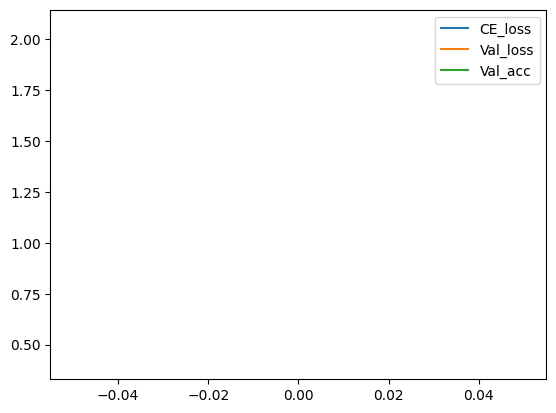

This fold, the test loss is:  tensor(0.5651)  acc is  0.7665
Fold 2
Dataloader Success---------------------
|                                                                                   |
Learning rate = 0.000010

Epoch 0, loss 10.2131, ce_loss 1.9473, reg_loss 8.2658
Epoch 0, loss 10.2131
Epoch 0, val_loss 1.2069, val_acc 0.4023
Epoch 0, val_loss 1.2069, val_acc 0.4023
This fold, the best val loss is:  1.2068971662936847


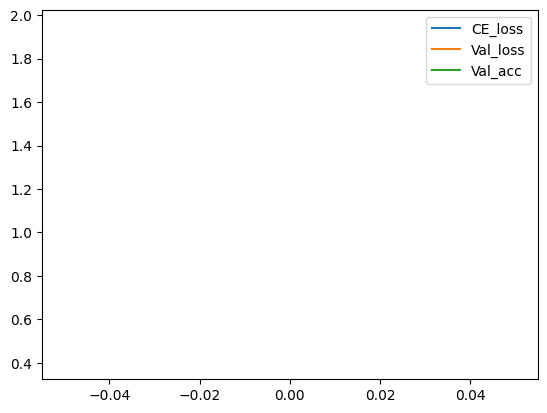

This fold, the test loss is:  tensor(0.5651)  acc is  0.7665


In [86]:

# 5 fold

# kfold = StratifiedKFold(n_splits=5)
kfold = StratifiedKFold(n_splits=2)


def getdataloader(index, isshuffle=False):
    dataset = GPRDataset(train_y[index],
                         list(itemgetter(*index)(all_graphs)),
                         list(itemgetter(*index)(offsets_NoPUNC)),
                         list(itemgetter(*index)(gcn_offsets)),
                         list(itemgetter(*index)(PROPN_bert)))
    dataloarder = DataLoader(dataset, collate_fn=collate,
                             batch_size=4, shuffle=isshuffle)

    return dataloarder



test_predict_lst = []  # the test output for every fold
for train_index, val_index in kfold.split(df_train_val, train_y):  # 循环5次
    print("=" * 20)
    print(f"Fold {len(test_predict_lst) + 1}")
    print("=" * 20)

    val_dataloarder = getdataloader(val_index)
    train_dataloarder = getdataloader(train_index, True)
    print('Dataloader Success---------------------')

    model = GPRModel().to(device)
    loss_func = nn.CrossEntropyLoss()
    lr_value = 0.0001
    optimizer = optim.Adam(model.parameters(), lr=lr_value)
    # ce: CrossEntropy 内含训练+验证、model.train()
    ce_losses, val_losses, val_accs = trainmodel(train_dataloarder,
                                                 val_dataloarder,
                                                 model, loss_func, optimizer, lr_value)

    plt.figure()
    plt.plot(ce_losses, label='CE_loss')
    plt.plot(val_losses, label='Val_loss')
    plt.plot(val_accs, label='Val_acc')
    plt.legend()  # 添加图例
    plt.show()

    # 测试
    test_loss = 0.
    test_predict = None
    model.load_state_dict(torch.load(base_dir + 'best_model.pth'))
    model.to(device)
    model.eval()
    for iter, (batched_graph, offsets_bert, offsets_gcn, bert_embeddings,
               labels) in enumerate(test_dataloarder):

        offsets_gcn = offsets_gcn.to(device)
        bert_embeddings = bert_embeddings.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            prediction = model(offsets_bert, offsets_gcn, bert_embeddings, batched_graph)

        if test_predict is None:
            test_predict = prediction
        else:
            test_predict = torch.cat((test_predict, prediction), 0)
        loss = loss_func(prediction, labels)
        test_loss += loss

    acc = metrics.accuracy_score(test_y, torch.argmax(test_predict, -1).cpu().numpy())
    test_loss /= (iter + 1)
    print('This fold, the test loss is: ', test_loss, " acc is ", acc)
    test_predict_lst.append(test_predict)


In [82]:
## Test
print('test_predict_lst')
# (5,2000,3) 3独热的分类得分，需要softmax
print_variable_structure(test_predict_lst)
print(test_predict_lst[0][0])
print('train_y')
# (2454,)
print_variable_structure(train_y)
print(train_y[:5])

test_predict_lst
Type: <class 'list'>
Shape: 5
Index: 0
  Type: <class 'torch.Tensor'>
  Shape: torch.Size([2000, 3])
  Data Type: torch.float32
  Index: 0
    Type: <class 'torch.Tensor'>
    Shape: torch.Size([3])
    Data Type: torch.float32
    Index: 0
      Type: <class 'torch.Tensor'>
      Shape: torch.Size([])
      Data Type: torch.float32
tensor([1.4402, 0.3232, 0.1801])
train_y
Type: <class 'numpy.ndarray'>
Shape: (2454,)
Data Type: int64
Index: 0
  Type: <class 'numpy.int64'>
[1 0 0 1 0]


In [94]:
# Test Part
test_predict_arr = [torch.softmax(pre.cpu(), -1).clamp(1e-4, 1 - 1e-4).numpy() for pre in test_predict_lst]
# 求k fold得到的 k 个概率的均值
final_test_preds = np.mean(test_predict_arr, axis=0)

In [95]:
print('test_predict_arr')
# (k, 2000, 3)
print_variable_structure(test_predict_arr)
# 不同折的测试结果竟然相等!
# [0.6207685  0.20315523 0.1760763 ]
print(test_predict_arr[0][0])
print(test_predict_arr[1][0])

print('final_test_preds')
# (2000, 3)
print_variable_structure(final_test_preds)
# [0.6207685  0.20315523 0.1760763 ]
print(final_test_preds[0])

test_predict_arr
Type: <class 'list'>
Shape: 2
Index: 0
  Type: <class 'numpy.ndarray'>
  Shape: (2000, 3)
  Data Type: float32
  Index: 0
    Type: <class 'numpy.ndarray'>
    Shape: (3,)
    Data Type: float32
    Index: 0
      Type: <class 'numpy.float32'>
[0.6207685  0.20315523 0.1760763 ]
[0.6207685  0.20315523 0.1760763 ]
final_test_preds
Type: <class 'numpy.ndarray'>
Shape: (2000, 3)
Data Type: float32
Index: 0
  Type: <class 'numpy.ndarray'>
  Shape: (3,)
  Data Type: float32
  Index: 0
    Type: <class 'numpy.float32'>
[0.6207685  0.20315523 0.1760763 ]


In [97]:

def extract_target(df):
    df["Neither"] = 0
    df.loc[~(df['A-coref'] | df['B-coref']), "Neither"] = 1

    df["target"] = 0
    df.loc[df['B-coref'] == 1, "target"] = 1
    df.loc[df["Neither"] == 1, "target"] = 2
    return df

# target 是正确结果，取值为 0 1 2
test_df = extract_target(df_test)
log_loss(test_df.target, final_test_preds)

# result 是预测结果，取值为 0 1 2
result = np.argmax(final_test_preds, -1).reshape(len(final_test_preds), 1)

# 保存结果
df_sub = pd.DataFrame(np.concatenate([final_test_preds, result], -1), columns=["A", "B", "NEITHER", 'result'])
df_sub["ID"] = test_df.ID
df_sub["target"] = test_df["target"]
df_sub = df_sub[['ID', "A", "B", "NEITHER", "result", "target"]]
df_sub.to_csv(base_dir + "submission_415_copy3.csv", index=False)

acc = metrics.accuracy_score(test_df["target"].values, np.argmax(final_test_preds, -1))

In [104]:
## Test
print('test_df.target')
print_variable_structure(test_df.target)
print(test_df.target[:5])

print('result')
print_variable_structure(result)
print(result[:5])

print('df_sub')
print(df_sub.head(20))
print('acc', acc)

test_df.target
Type: <class 'pandas.core.series.Series'>
Attributes: ['_is_copy', '_mgr', '_item_cache', '_attrs', '_flags', '_name', '_index', '_cacher']
Attribute: _is_copy
  Type: <class 'NoneType'>
0    0
1    0
2    1
3    1
4    1
Name: target, dtype: int64
result
Type: <class 'numpy.ndarray'>
Shape: (2000, 1)
Data Type: int64
Index: 0
  Type: <class 'numpy.ndarray'>
  Shape: (1,)
  Data Type: int64
  Index: 0
    Type: <class 'numpy.int64'>
[[0]
 [0]
 [1]
 [1]
 [1]]
df_sub
                ID         A         B   NEITHER  result  target
0    development-1  0.620768  0.203155  0.176076     0.0       0
1    development-2  0.949732  0.014193  0.036075     0.0       0
2    development-3  0.020058  0.951935  0.028007     1.0       1
3    development-4  0.076145  0.472655  0.451201     1.0       1
4    development-5  0.076833  0.898564  0.024602     1.0       1
5    development-6  0.835568  0.151861  0.012571     0.0       0
6    development-7  0.798665  0.152538  0.048796     0.0    